In [1]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize

import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import LabelEncoder

# 3. Model construction

## 3.1.1 Keep only useful columns

In [2]:
train_new = pd.read_csv('train_updated.csv')

/Users/xinyuliu/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
pd.set_option('display.max_columns', None)
train_new.head()

,channelGrouping,date,fullVisitorId,visitNumber,device.browser,device.operatingSystem,device.deviceCategory,geoNetwork.continent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.timeOnSite,totals.transactions,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,revenue_generation_status
0,Organic Search,2017-10-16,3162355547410993243,1,Firefox,Windows,desktop,Europe,Germany,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),1,1,1.0,1,0.0,0.0,0.0,(not set),google,organic,0
1,Referral,2017-10-16,8934116514970143966,6,Chrome,Chrome OS,desktop,Americas,United States,California,San Francisco-Oakland-San Jose CA,Cupertino,(not set),2,2,0.0,0,28.0,0.0,0.0,(not set),sites.google.com,referral,0
2,Direct,2017-10-16,7992466427990357681,1,Chrome,Android,mobile,Americas,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,windjammercable.net,2,2,0.0,1,38.0,0.0,0.0,(not set),(direct),(none),0
3,Organic Search,2017-10-16,9075655783635761930,1,Chrome,Windows,desktop,Asia,Turkey,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,2,2,0.0,1,1.0,0.0,0.0,(not set),google,organic,0
4,Organic Search,2017-10-16,6960673291025684308,1,Chrome,Windows,desktop,Americas,Mexico,not available in demo dataset,not available in demo dataset,not available in demo dataset,prod-infinitum.com.mx,2,2,0.0,1,52.0,0.0,0.0,(not set),google,organic,0


In [4]:
test = pd.read_csv("test-flattened.csv")

/Users/xinyuliu/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
train_new.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'visitNumber',
       'device.browser', 'device.operatingSystem', 'device.deviceCategory',
       'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.region',
       'geoNetwork.metro', 'geoNetwork.city', 'geoNetwork.networkDomain',
       'totals.hits', 'totals.pageviews', 'totals.bounces', 'totals.newVisits',
       'totals.timeOnSite', 'totals.transactions', 'totals.transactionRevenue',
       'trafficSource.campaign', 'trafficSource.source',
       'trafficSource.medium', 'revenue_generation_status'],
      dtype='object')

In [6]:
test['revenue_generation_status']=test['totals.transactions'].apply(lambda x: 1 if x>0 else 0)

In [7]:
from datetime import datetime
for df in [train_new,test]:
    df['date']=pd.to_datetime(df['date'],format='%Y-%m-%d')
    df['day']=df['date'].dt.day
    df['month']=df['date'].dt.month
    df['year']=df['date'].dt.year

In [8]:
useful = train_new.columns
useless_train = set(useful)-set(test.columns)
useless_train

set()

In [9]:
useful = train_new.columns
useless_test = set(test.columns)-set(useful)
useless_test

{'customDimensions',
 'device.browserSize',
 'device.browserVersion',
 'device.flashVersion',
 'device.isMobile',
 'device.language',
 'device.mobileDeviceBranding',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.operatingSystemVersion',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'geoNetwork.subContinent',
 'hits',
 'socialEngagementType',
 'totals.sessionQualityDim',
 'totals.totalTransactionRevenue',
 'totals.visits',
 'trafficSource.adContent',
 'trafficSource.adwordsClickInfo.adNetworkType',
 'trafficSource.adwordsClickInfo.criteriaParameters',
 'trafficSource.adwordsClickInfo.gclId',
 'trafficSource.adwordsClickInfo.isVideoAd',
 'trafficSource.adwordsClickInfo.page',
 'trafficSource.adwordsClickInfo.slot',
 'trafficSource.isTrueDirect',
 'trafficSource.keyword',
 'trafficSource.referra

In [10]:
test.drop(useless_test,axis=1, inplace=True)

In [11]:
train_new.shape

(1708337, 27)

In [12]:
test.shape

(401589, 27)

## 3.1.2 Encoding categorical variables

In [13]:
cat_cols = list(train_new.columns[train_new.dtypes=='object'])
num_cols = list(train_new.columns[(train_new.dtypes=='int64')|(train_new.dtypes=='float64')])

In [14]:
num_cols

['visitNumber',
 'totals.hits',
 'totals.pageviews',
 'totals.bounces',
 'totals.newVisits',
 'totals.timeOnSite',
 'totals.transactions',
 'totals.transactionRevenue',
 'revenue_generation_status',
 'day',
 'month',
 'year']

In [15]:
cat_cols.remove('fullVisitorId')

In [16]:
num_cols.remove('totals.transactions')
num_cols.remove('revenue_generation_status')
num_cols.remove('totals.transactionRevenue')

**tried get dummies and one hot encoding but get out-of-memory error, referenced code from kaggle**

In [17]:
from sklearn.preprocessing import LabelEncoder
for col in cat_cols:
    print("column {} is being encoded".format(col))
    enc = LabelEncoder()
    enc.fit(pd.concat([train_new[col],test[col]]).astype("str"))
    train_new[col] = enc.transform(train_new[col].astype("str"))
    test[col] = enc.transform(test[col].astype("str"))

column channelGrouping is being encoded
column device.browser is being encoded
column device.operatingSystem is being encoded
column device.deviceCategory is being encoded
column geoNetwork.continent is being encoded
column geoNetwork.country is being encoded
column geoNetwork.region is being encoded
column geoNetwork.metro is being encoded
column geoNetwork.city is being encoded
column geoNetwork.networkDomain is being encoded
column trafficSource.campaign is being encoded
column trafficSource.source is being encoded
column trafficSource.medium is being encoded


In [18]:
train_new.head()

,channelGrouping,date,fullVisitorId,visitNumber,device.browser,device.operatingSystem,device.deviceCategory,geoNetwork.continent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.timeOnSite,totals.transactions,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,revenue_generation_status,day,month,year
0,4,2017-10-16,3162355547410993243,1,64,22,0,4,75,517,129,1096,0,1,1,1.0,1,0.0,0.0,0.0,4,117,5,0,16,10,2017
1,6,2017-10-16,8934116514970143966,6,55,3,0,2,219,74,104,256,0,2,2,0.0,0,28.0,0.0,0.0,4,339,6,0,16,10,2017
2,2,2017-10-16,7992466427990357681,1,55,1,1,2,219,517,129,1096,47195,2,2,0.0,1,38.0,0.0,0.0,4,0,0,0,16,10,2017
3,4,2017-10-16,9075655783635761930,1,55,22,0,3,211,517,129,1096,44691,2,2,0.0,1,1.0,0.0,0.0,4,117,5,0,16,10,2017
4,4,2017-10-16,6960673291025684308,1,55,22,0,2,132,517,129,1096,33811,2,2,0.0,1,52.0,0.0,0.0,4,117,5,0,16,10,2017


tried but not working One hot encoding
from sklearn.preprocessing import OneHotEncoder

def OneHotEncoding(df, enc, categories):
    transformed = pd.DataFrame(enc.transform(df[categories]).toarray(), columns=enc.get_feature_names(categories))
    return pd.concat([df.reset_index(drop=True), transformed], axis=1).drop(categories, axis=1)

categories = cat_cols
enc_ohe = OneHotEncoder()
enc_ohe.fit(X_train[categories])

X_train = OneHotEncoding(X_train, enc_ohe, categories)
X_test = OneHotEncoding(X_test, enc_ohe, categories)

## 3.1.3 Normalize numerical features

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train[num_cols])
X_train[num_cols] = scaler.transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

NameError: name 'X_train' is not defined

## 3.1.4 Split X and y in train and test

In [20]:
train_new=train_new.sort_values(by='date').reset_index().drop('index',axis=1)
train_new

,channelGrouping,date,fullVisitorId,visitNumber,device.browser,device.operatingSystem,device.deviceCategory,geoNetwork.continent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.timeOnSite,totals.transactions,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,revenue_generation_status,day,month,year
0,2,2016-08-01,6849420071276447389,1,102,7,0,2,219,269,12,173,44691,33,13,0.0,1,129.0,0.0,0.0,4,0,0,0,1,8,2016
1,6,2016-08-01,1231590494443171080,2,55,3,0,2,219,74,104,621,0,31,23,0.0,0,1380.0,0.0,0.0,4,0,0,0,1,8,2016
2,2,2016-08-01,6751290259214798595,1,55,7,0,2,219,517,129,1096,0,31,21,0.0,1,248.0,0.0,0.0,4,0,0,0,1,8,2016
3,6,2016-08-01,3213840074316400693,2,55,7,0,2,219,517,129,1096,0,32,24,0.0,0,295.0,1.0,167400000.0,4,0,0,1,1,8,2016
4,6,2016-08-01,2987126973357946088,1,55,7,0,2,219,74,104,621,8906,32,24,0.0,1,507.0,0.0,0.0,4,0,0,0,1,8,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1708332,6,2018-04-30,571437033570427147,1,55,22,0,2,219,517,129,1096,46268,1,1,1.0,1,0.0,0.0,0.0,4,12,6,0,30,4,2018
1708333,4,2018-04-30,8269860486104002425,1,55,1,1,3,202,517,129,1096,18403,1,1,1.0,1,0.0,0.0,0.0,4,117,5,0,30,4,2018
1708334,4,2018-04-30,7917688562308867174,2,55,22,0,2,219,517,129,1096,24259,1,1,1.0,0,0.0,0.0,0.0,4,117,5,0,30,4,2018
1708335,6,2018-04-30,5884793925108484385,2,55,22,0,1,130,517,129,1096,28591,1,1,1.0,0,0.0,0.0,0.0,4,12,6,0,30,4,2018


In [21]:
X_train = train_new[cat_cols+num_cols]
y_train = train_new['totals.transactionRevenue'].apply(lambda x: np.log(x) if x!=0 else np.log(x+1))


X_test =test[cat_cols+num_cols]
y_test = test['totals.transactionRevenue'].apply(lambda x: np.log(x) if x!=0 else np.log(x+1))

In [22]:
X_train.columns

Index(['channelGrouping', 'device.browser', 'device.operatingSystem',
       'device.deviceCategory', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.region', 'geoNetwork.metro', 'geoNetwork.city',
       'geoNetwork.networkDomain', 'trafficSource.campaign',
       'trafficSource.source', 'trafficSource.medium', 'visitNumber',
       'totals.hits', 'totals.pageviews', 'totals.bounces', 'totals.newVisits',
       'totals.timeOnSite', 'day', 'month', 'year'],
      dtype='object')

In [23]:
X_train.shape

(1708337, 22)

In [24]:
# Split the train dataset into development and valid based on time 
dev_df = train_new[train_new['date']<='2017-12-31']
val_df = train_new[train_new['date']>'2017-12-31']

X_dev = dev_df[cat_cols+num_cols]
y_dev= dev_df['totals.transactionRevenue'].apply(lambda x: np.log(x) if x!=0 else np.log(x+1))

X_val= val_df[cat_cols+num_cols]
y_val= val_df['totals.transactionRevenue'].apply(lambda x: np.log(x) if x!=0 else np.log(x+1))

## 3.2 Build models

## 3.2.1 Ridge Regression

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV


params = {'alpha':[0.001, 0.01, 0.1, 0.3, 0.5, 0.8]} 
Ridge_grid = GridSearchCV(linear_model.Ridge(normalize=True), params,cv=5)
Ridge_grid.fit(X_train,np.log(y_train))
best_Ridge = linear_model.Ridge(normalize=True,alpha = Ridge_grid.best_params_['alpha'])
best_Ridge.fit(X_train,np.log(y_train))

/Users/xinyuliu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
/Users/xinyuliu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the 

Ridge(alpha=0.01, normalize=True)

In [26]:
X_test=X_test.fillna(0)

In [27]:
pred_test = best_Ridge.predict(X_test)

In [28]:
pred_test_df = pd.DataFrame({'fullVisitorId':test['fullVisitorId'].values})
pred_test_df['real_transactionRevenue'] = test["totals.transactionRevenue"].values
pred_test_df['predicted_transactionRevenue'] = np.exp(pred_test)

In [29]:
pred_test_df=pred_test_df.fillna(1)
pred_test_df

,fullVisitorId,real_transactionRevenue,predicted_transactionRevenue
0,7460955084541987166,1.0,0.858877
1,460252456180441002,1.0,0.813138
2,3461808543879602873,1.0,0.857409
3,975129477712150630,1.0,0.869916
4,8381672768065729990,1.0,0.816744
...,...,...,...
401584,6701149525099562370,1.0,0.818232
401585,6154541330147351453,1.0,0.829823
401586,6013469762773705448,1.0,0.835090
401587,4565378823441900999,1.0,0.838743


In [30]:
from sklearn import metrics
metrics.mean_squared_error(np.log(pred_test_df["real_transactionRevenue"].values), 
                           np.log(pred_test_df["predicted_transactionRevenue"].values))


3.5617920401806584

## 3.2.2 RandomForest Regressor

In [31]:
from sklearn.ensemble import RandomForestRegressor
X_test=X_test.fillna(0)

# Random Forest
regressor_RF = RandomForestRegressor()
regressor_RF.fit(X_train,y_train)
pred_test = regressor_RF.predict(X_test)

In [32]:
pred_test_df = pd.DataFrame({'fullVisitorId':test['fullVisitorId'].values})
pred_test_df['real_transactionRevenue'] = test["totals.transactionRevenue"].values
pred_test_df['predicted_transactionRevenue'] = np.exp(pred_test)
pred_test_df=pred_test_df.fillna(1)

metrics.mean_squared_error(np.log(pred_test_df["real_transactionRevenue"].values), 
                           np.log(pred_test_df["predicted_transactionRevenue"].values))

2.8011700147374627

In [88]:
def print_grid_search_metrics(gs):
    print ("Best score: " + str(gs.best_score_))
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(best_parameters.keys()):
        print(param_name + ':' + str(best_parameters[param_name]))

In [ ]:
# Possible hyperparamter options for Random Forest
# Choose the number of trees
parameters = {
    'n_estimators' : [60,80,100],
    'max_depth': [1,5,10]
}
Grid_RF = GridSearchCV(RandomForestRegressor(),parameters, cv=5)
Grid_RF.fit(X_train, y_train)
print_grid_search_metrics(Grid_RF)

In [86]:
# check feature importance of random forest for feature selection
importances = regressor_RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature importance ranking by Random Forest Model:")
for ind in range(X_train.shape[1]):
    print ("{0} : {1}".format(X_train.columns[indices[ind]],100*round(importances[indices[ind]], 4)))

Feature importance ranking by Random Forest Model:
totals.pageviews : 21.73
totals.timeOnSite : 17.53
day : 9.790000000000001
totals.hits : 8.23
month : 6.36
geoNetwork.country : 5.84
geoNetwork.networkDomain : 5.09
visitNumber : 4.2299999999999995
geoNetwork.city : 3.52
device.operatingSystem : 2.77
channelGrouping : 2.31
geoNetwork.metro : 2.12
geoNetwork.region : 2.08
year : 2.01
totals.newVisits : 1.49
device.deviceCategory : 1.41
trafficSource.source : 1.09
device.browser : 1.02
trafficSource.medium : 0.96
trafficSource.campaign : 0.29
geoNetwork.continent : 0.12
totals.bounces : 0.0


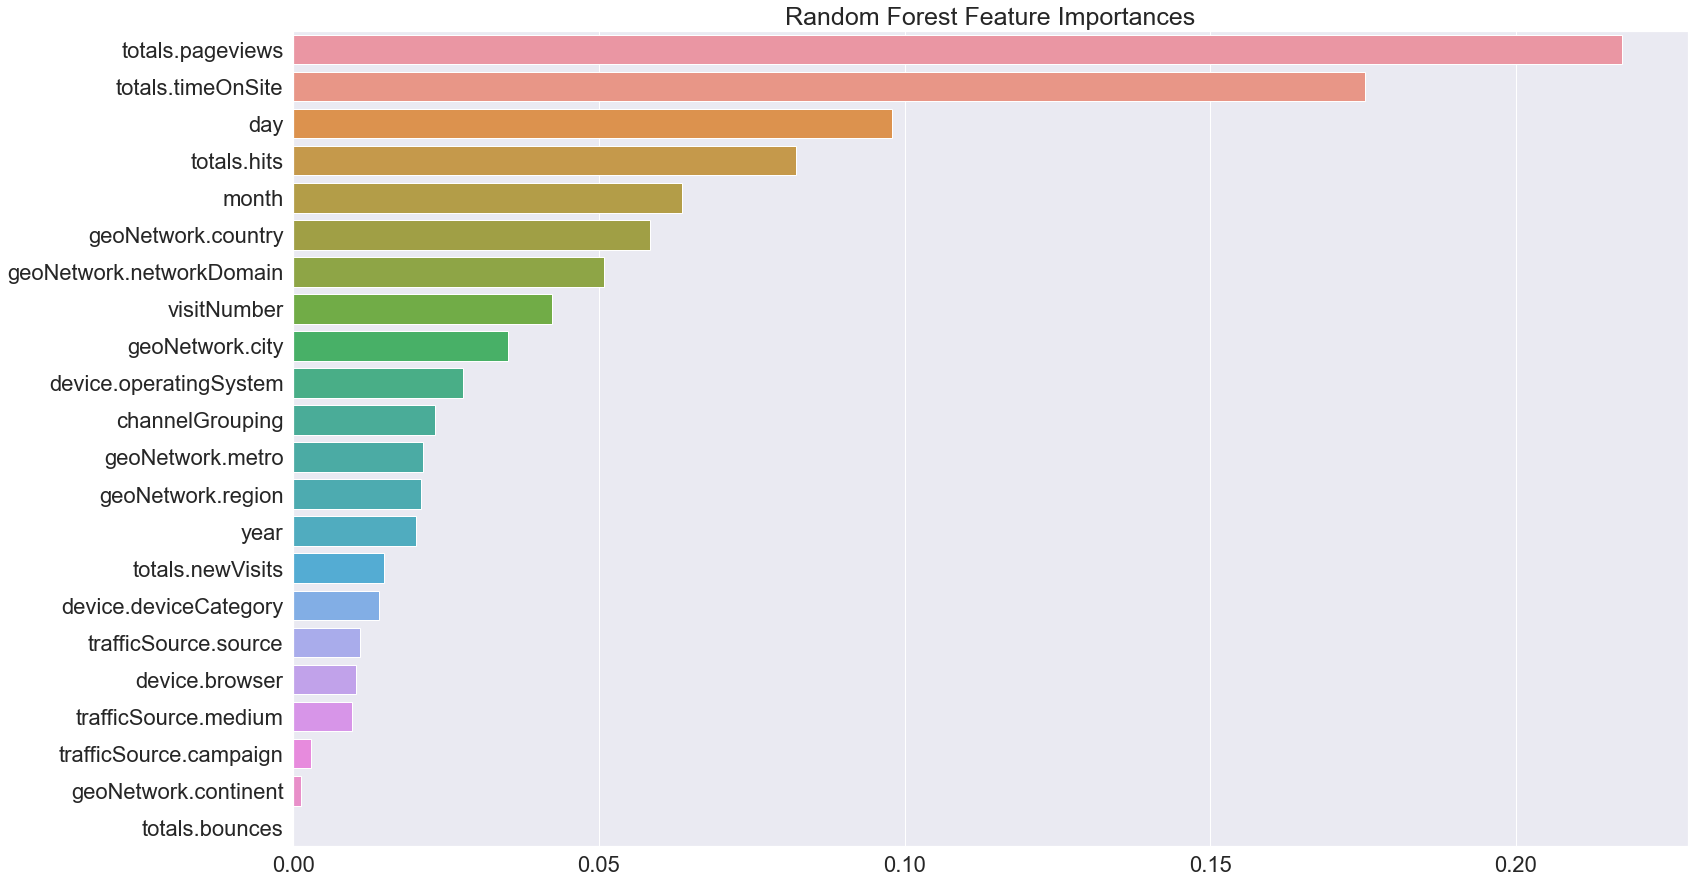

In [87]:
plt.figure(figsize=(25,15))
sns.set(font_scale=2)
feature_names = np.array(cat_cols+num_cols)
sns.barplot(x=importances[indices],y=feature_names[indices])
plt.title("Random Forest Feature Importances", fontsize=25)
plt.show()

## 3.2.3 LGBMRegressor

In [58]:
%time
import lightgbm
from lightgbm import LGBMRegressor
lgb = LGBMRegressor(num_leaves=13,
                    learning_rate=0.05,
                   n_estimators=120,
                   reg_alpha=1)
lgb.fit(X_dev,y_dev)

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 8.82 µs


LGBMRegressor(learning_rate=0.05, n_estimators=120, num_leaves=13, reg_alpha=1)

In [59]:
%time
eval_predict = lgb.predict(X_val)
test_predict = lgb.predict(X_test)

# eval error
pred_test_df = pd.DataFrame({'fullVisitorId':val_df['fullVisitorId'].values})
pred_test_df['real_transactionRevenue'] = val_df["totals.transactionRevenue"].values
pred_test_df['predicted_transactionRevenue'] = np.exp(eval_predict)

pred_test_df=pred_test_df.fillna(0)


metrics.mean_squared_error(np.log(pred_test_df["real_transactionRevenue"].values+1), 
                           np.log(pred_test_df["predicted_transactionRevenue"].values+1))

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 11 µs


2.410137389977267

In [60]:
# test error
pred_test_df = pd.DataFrame({'fullVisitorId':test['fullVisitorId'].values})
pred_test_df['real_transactionRevenue'] = test["totals.transactionRevenue"].values
pred_test_df['predicted_transactionRevenue'] = np.exp(test_predict)

pred_test_df=pred_test_df.fillna(0)

metrics.mean_squared_error(np.log(pred_test_df["real_transactionRevenue"].values+1), 
                           np.log(pred_test_df["predicted_transactionRevenue"].values+1))

3.0386947621233684

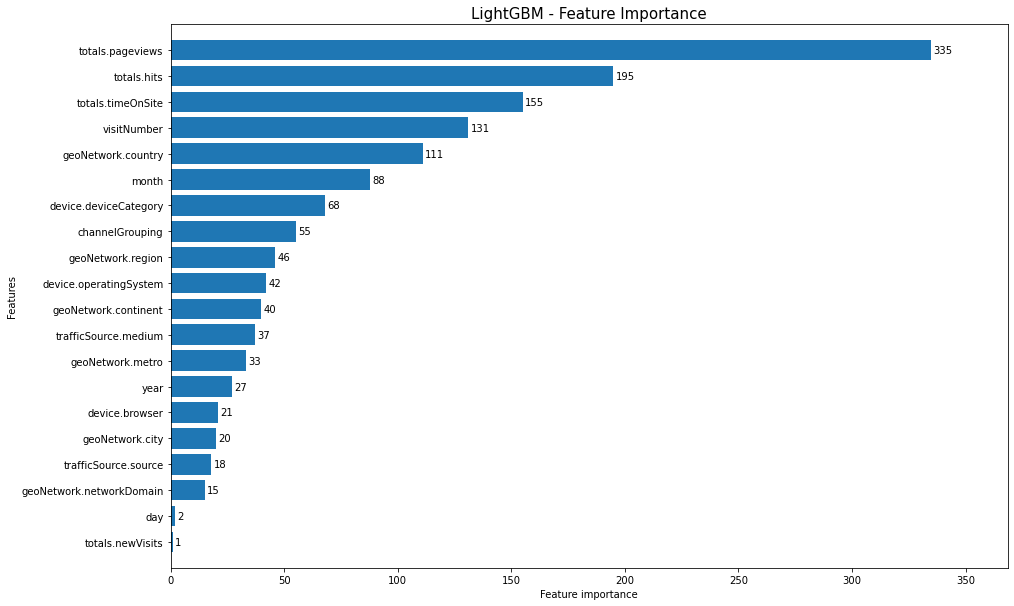

In [61]:
# feature importance
fig, ax = plt.subplots(figsize=(15,10))
lightgbm.plot_importance(lgb, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

## 3.2.3 XGBRegressor

In [37]:
import xgboost
from xgboost import XGBRegressor

xgb = XGBRegressor(max_depth=10,
                  alpha=0.1,
                  eta=0.1,
                  seed=250)
xgb.fit(X_dev,y_dev)

XGBRegressor(alpha=0.1, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.100000001, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=10, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, ...)

In [38]:
%time
train_predict = xgb.predict(X_dev)
eval_predict = xgb.predict(X_val)
test_predict = xgb.predict(X_test)

# eval error
pred_test_df = pd.DataFrame({'fullVisitorId':val_df['fullVisitorId'].values})
pred_test_df['real_transactionRevenue'] = val_df["totals.transactionRevenue"].values
pred_test_df['predicted_transactionRevenue'] = np.exp(eval_predict)

pred_test_df=pred_test_df.fillna(0)


metrics.mean_squared_error(np.log(pred_test_df["real_transactionRevenue"].values+1), 
                           np.log(pred_test_df["predicted_transactionRevenue"].values+1))


CPU times: user 3 µs, sys: 3 µs, total: 6 µs
Wall time: 5.96 µs


2.4585606372749873

In [39]:
# test error
pred_test_df = pd.DataFrame({'fullVisitorId':test['fullVisitorId'].values})
pred_test_df['real_transactionRevenue'] = test["totals.transactionRevenue"].values
pred_test_df['predicted_transactionRevenue'] = np.exp(test_predict)

pred_test_df=pred_test_df.fillna(0)

metrics.mean_squared_error(np.log(pred_test_df["real_transactionRevenue"].values+1), 
                           np.log(pred_test_df["predicted_transactionRevenue"].values+1))

3.0949825853716058

In [78]:
importances = xgb.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature importance ranking by XGBoost Regressor:")
for ind in range(X_train.shape[1]):
    print ("{0} : {1}".format(X_train.columns[indices[ind]],100*round(importances[indices[ind]], 4)))

Feature importance ranking by XGBoost Regressor:
totals.pageviews : 26.069998741149902
geoNetwork.country : 11.60999983549118
device.deviceCategory : 7.460000365972519
visitNumber : 5.090000107884407
year : 4.230000078678131
trafficSource.source : 4.069999977946281
totals.timeOnSite : 4.019999876618385
geoNetwork.metro : 3.9500001817941666
trafficSource.medium : 3.790000081062317
month : 3.7599999457597733
totals.hits : 3.750000149011612
geoNetwork.city : 3.359999880194664
geoNetwork.region : 3.0300000682473183
channelGrouping : 2.9999999329447746
day : 2.580000087618828
geoNetwork.networkDomain : 2.4700000882148743
device.operatingSystem : 2.3399999365210533
trafficSource.campaign : 2.329999953508377
device.browser : 2.0400000736117363
geoNetwork.continent : 1.0400000028312206
totals.bounces : 0.0
totals.newVisits : 0.0


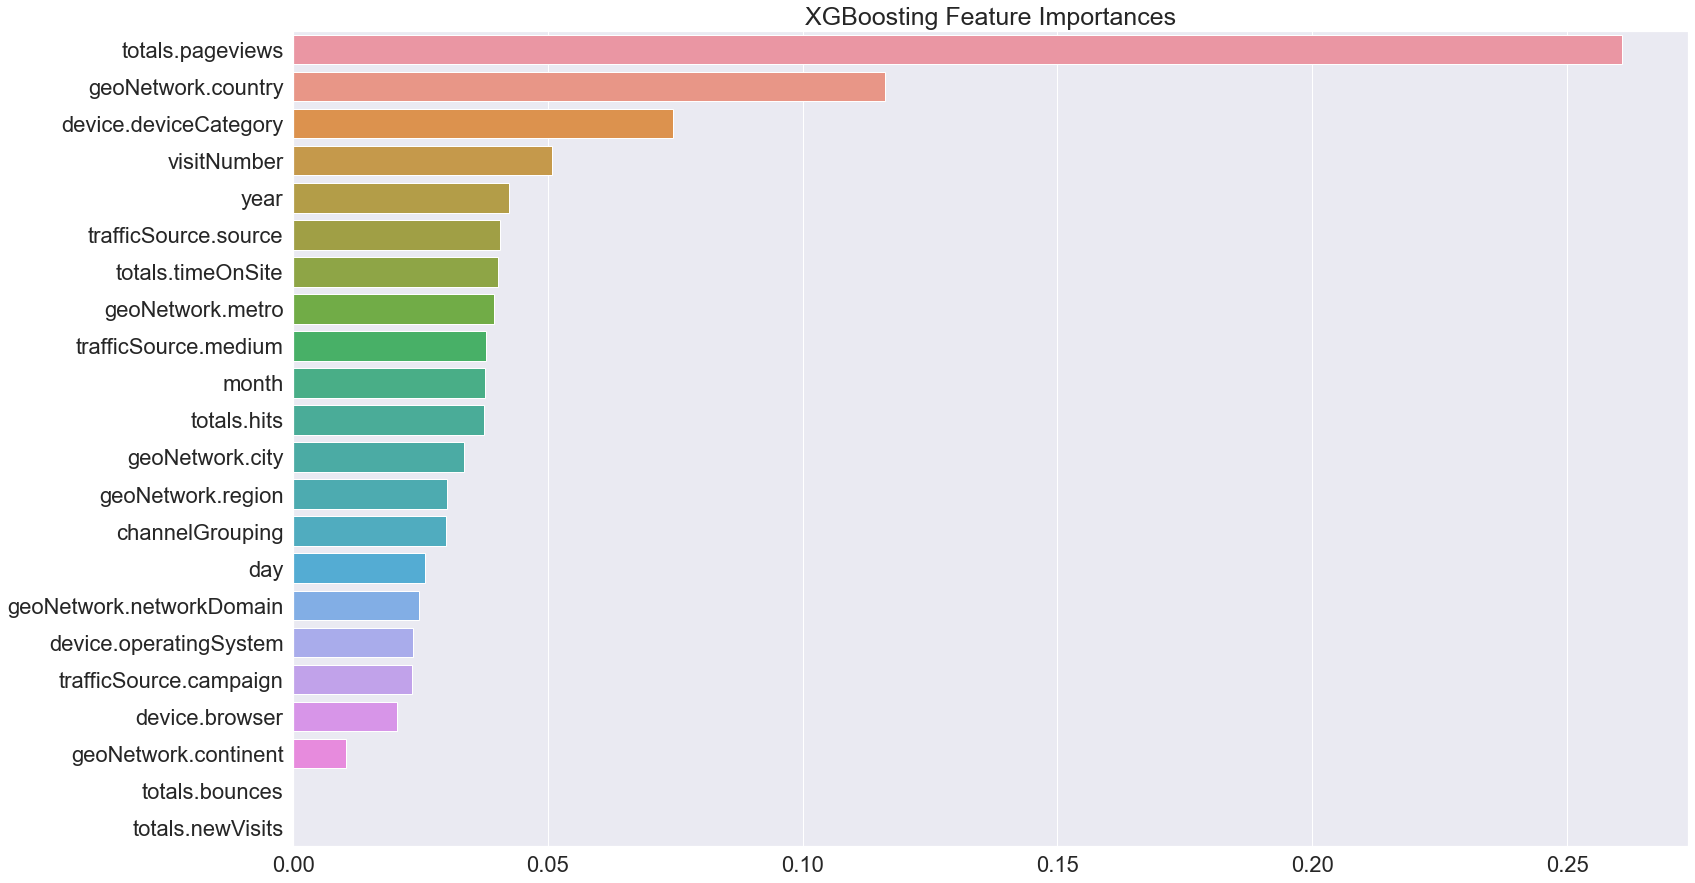

In [85]:
plt.figure(figsize=(25,15))
sns.set(font_scale=2)
feature_names = np.array(cat_cols+num_cols)
sns.barplot(x=importances[indices],y=feature_names[indices])
plt.title("XGBoosting Feature Importances", fontsize=25)
plt.show()

## 3.2.4 Neural Network LSTM

In [42]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [44]:
lstm = Sequential()
lstm.add(LSTM(80,input_shape=(X_dev.shape[1],1)))
lstm.add(Dense(30,activation='relu'))
lstm.add(Dropout(0.2))
lstm.add(Dense(20,activation='relu'))
lstm.add(Dense(15,activation='relu'))
lstm.add(Dense(1,activation='sigmoid'))
lstm.compile(loss='mean_squared_error',optimizer='adam',metrics='accuracy')

row = X_dev.shape[0]
col = X_dev.shape[1]
dev_new = X_dev.values.reshape(row,col,1)
lstm.fit(x=dev_new,
         y=y_dev,
         batch_size=280,
         epochs=15,
         verbose=1)

Epoch 1/15
4876/4876 [==============================] - 142s 29ms/step - loss: 2.6672 - accuracy: 0.9320
Epoch 2/15
4876/4876 [==============================] - 147s 30ms/step - loss: 2.5440 - accuracy: 0.9412
Epoch 3/15
4876/4876 [==============================] - 144s 30ms/step - loss: 2.5195 - accuracy: 0.9437
Epoch 4/15
4876/4876 [==============================] - 149s 31ms/step - loss: 2.4985 - accuracy: 0.9453
Epoch 5/15
4876/4876 [==============================] - 158s 32ms/step - loss: 2.4770 - accuracy: 0.9464
Epoch 6/15
4876/4876 [==============================] - 150s 31ms/step - loss: 2.4613 - accuracy: 0.9477
Epoch 7/15
4876/4876 [==============================] - 163s 33ms/step - loss: 2.4513 - accuracy: 0.9479
Epoch 8/15
4876/4876 [==============================] - 155s 32ms/step - loss: 2.4431 - accuracy: 0.9484
Epoch 9/15
4876/4876 [==============================] - 152s 31ms/step - loss: 2.4383 - accuracy: 0.9489
Epoch 10/15
4876/4876 [==============================] 

In [45]:
%time
eval_new = X_val.values.reshape(X_val.shape[0],X_val.shape[1],1)
test_new = X_test.values.reshape(X_test.shape[0],X_test.shape[1],1)
eval_predict = lstm.predict(eval_new)
test_predict = lstm.predict(test_new)

# eval error
pred_test_df = pd.DataFrame({'fullVisitorId':val_df['fullVisitorId'].values})
pred_test_df['real_transactionRevenue'] = val_df["totals.transactionRevenue"].values
pred_test_df['predicted_transactionRevenue'] = np.exp(eval_predict)

pred_test_df=pred_test_df.fillna(0)

metrics.mean_squared_error(np.log(pred_test_df["real_transactionRevenue"].values+1), 
                           np.log(pred_test_df["predicted_transactionRevenue"].values+1))

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 21 µs
12550/12550 [==============================] - 37s 3ms/step


2.4510454670993544

In [46]:
# test error
%time
pred_test_df = pd.DataFrame({'fullVisitorId':test['fullVisitorId'].values})
pred_test_df['real_transactionRevenue'] = test["totals.transactionRevenue"].values
pred_test_df['predicted_transactionRevenue'] = np.exp(test_predict)

pred_test_df=pred_test_df.fillna(0)

metrics.mean_squared_error(np.log(pred_test_df["real_transactionRevenue"].values+1), 
                           np.log(pred_test_df["predicted_transactionRevenue"].values+1))

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 5.01 µs


3.061697003003064

## 3.2.5 Ensamble method of RF, XGB, LGB

In [66]:
from sklearn.ensemble import VotingRegressor
models=[('rf', regressor_RF), ('xgboosting', xgb),('lgboosting',lgb)]
weights=[0.2,0.4,0.4]
ensemble = VotingRegressor(estimators=models, weights=weights)

In [67]:
%time
ensemble.fit(X_dev,y_dev)
eval_predict = ensemble.predict(X_val)
test_predict = ensemble.predict(X_test)

# eval error
pred_test_df = pd.DataFrame({'fullVisitorId':val_df['fullVisitorId'].values})
pred_test_df['real_transactionRevenue'] = val_df["totals.transactionRevenue"].values
pred_test_df['predicted_transactionRevenue'] = np.exp(eval_predict)

pred_test_df=pred_test_df.fillna(0)


metrics.mean_squared_error(np.log(pred_test_df["real_transactionRevenue"].values+1), 
                           np.log(pred_test_df["predicted_transactionRevenue"].values+1))

CPU times: user 4 µs, sys: 3 µs, total: 7 µs
Wall time: 11 µs


2.4150789813718316

In [68]:
# test error
pred_test_df = pd.DataFrame({'fullVisitorId':test['fullVisitorId'].values})
pred_test_df['real_transactionRevenue'] = test["totals.transactionRevenue"].values
pred_test_df['predicted_transactionRevenue'] = np.exp(test_predict)

pred_test_df=pred_test_df.fillna(0)

metrics.mean_squared_error(np.log(pred_test_df["real_transactionRevenue"].values+1), 
                           np.log(pred_test_df["predicted_transactionRevenue"].values+1))

3.025782230082306